# Objective:
The objective of this exercise is to explore a simplified dataset with data from jobs and applicants to propose a feasible architecture for a recommendation engine.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# STEP 1: Data preparation and exploration
In this section I will have a quick look at the data, and analyse few KPI-s that might be important for the recommender engine.

In [2]:
# Let's read the datafiles
jobs_df = pd.read_csv("data/jobs.csv")
users_df = pd.read_csv("data/users.csv")
app_int_df = pd.read_csv("data/applications_interactions.csv")

print ("Jobs table has {0} shape".format(str(jobs_df.shape)))
print ("Users table has {0} shape".format(str(users_df.shape)))

print ("Applications intetactions table has {0} shape".format(str(app_int_df.shape)))

Jobs table has (1092096, 6) shape
Users table has (389708, 5) shape
Applications intetactions table has (1603111, 3) shape


In [3]:
jobs_df.head()

,JobID,City,State,Country,Zip5,StartDate
0,1,Washington,DC,US,20531.0,2012-03-07 13:17:01.643
1,4,Charlotte,NC,US,28217.0,2012-03-21 02:03:44.137
2,7,Winter Park,FL,US,32792.0,2012-03-02 16:36:55.447
3,8,Orlando,FL,US,NaN,2012-03-03 09:01:10.077
4,9,Orlando,FL,US,NaN,2012-03-03 09:01:11.88


In [4]:
users_df.head()

,UserID,City,State,Country,ZipCode
0,47,Paramount,CA,US,90723
1,72,La Mesa,CA,US,91941
2,80,Williamstown,NJ,US,08094
3,98,Astoria,NY,US,11105
4,123,Baton Rouge,LA,US,70808


In [5]:
app_int_df.head()

,UserID,JobID,ApplicationDate
0,47,169528,2012-04-04 15:56:23.537
1,47,284009,2012-04-06 01:03:00.003
2,47,2121,2012-04-05 02:40:27.753
3,47,848187,2012-04-05 02:37:02.673
4,47,733748,2012-04-05 22:44:06.653


### How many countries and states do we have?

In [6]:
jobs_df['Country'].value_counts()

US    1090644
AF        560
CZ        193
MX         93
TR         81
AT         80
AU         79
HU         47
RU         40
SK         39
ZA         33
JP         25
BR         23
MT         14
LU         12
BT          8
HR          8
FI          7
PH          7
DJ          6
BJ          6
BG          6
HK          5
LT          5
CL          5
PA          5
KR          4
UY          4
UM          4
GE          3
GI          3
NZ          3
PE          3
ID          2
CO          2
UZ          2
AO          2
EH          2
VN          2
SI          2
FX          2
UA          2
TW          2
KE          2
ZW          2
BM          1
EE          1
GH          1
TT          1
AW          1
NG          1
CR          1
PK          1
AX          1
UG          1
SR          1
VA          1
TZ          1
BS          1
DZ          1
TL          1
LV          1
Name: Country, dtype: int64

Most of the data is from US, but there are still few other countries 

In [7]:
# And what about the state?
jobs_df['State'].value_counts()

CA    109653
TX     98091
FL     71033
IL     58747
NY     54018
PA     49007
OH     45051
NJ     35180
NC     34564
GA     33454
VA     32349
MI     30005
MD     28531
AZ     27917
MA     26759
IN     26021
TN     24776
WI     23021
MN     22704
WA     22000
CO     21023
MO     20398
CT     16776
KY     16328
SC     15142
KS     13186
IA     12262
AL     12040
LA     11763
OR     10140
OK      9762
NV      7507
DC      7387
UT      7213
AR      6186
MS      5771
NM      5193
DE      5154
NE      4877
WV      3616
NH      3514
ID      3200
ND      2789
SD      2556
RI      2525
HI      2476
ME      2090
AK      2044
VT      1840
MT      1464
        1434
WY      1072
PR       406
VI        33
GU        32
NW        11
AS         2
MP         1
RM         1
Name: State, dtype: int64

### Join the tables for the analysis

In [8]:
# I will merge users table and the applications_interactions table with left joins, keeping all records at the users table
users_join_df = users_df.merge(app_int_df, how='left', left_on='UserID', right_on='UserID')
users_join_df.head(200)

# Double check: the lenght of this table should be: len(app_int_df) + number of unique users without applications
print ("Users_join table has {0} shape should be the same length as {1}".format(str(users_join_df.shape), 
                                               len(app_int_df) + len(users_df[~users_df['UserID'].isin(app_int_df['UserID'])]['UserID'].unique())))

Users_join table has (1671584, 7) shape should be the same length as 1671584


In [9]:
# And now, I will merge jobs table and users_join_df with using an outer join, keeping all the records at both sides
all_records_df = users_join_df.merge(jobs_df, how='outer', left_on='JobID', right_on='JobID', suffixes = ('_user', '_job'))

# Double check: the lenght of this table should be: len(users_join_df) + number of unique jobs without applications
print ("all_records_df table has {0} shape should be the same length as {1}".format(str(all_records_df.shape), 
                                               len(users_join_df) + len(jobs_df[~jobs_df['JobID'].isin(app_int_df['JobID'])]['JobID'].unique())))


all_records_df table has (2398012, 12) shape should be the same length as 2398012


In [10]:
# At these table we should see also jobs without ApplicationDate
all_records_df.sort_values(by=['StartDate']).head(100)

,UserID,City_user,State_user,Country_user,ZipCode,JobID,ApplicationDate,City_job,State_job,Country_job,Zip5,StartDate
1711035,NaN,NaN,NaN,NaN,NaN,212824.0,NaN,Tallahassee,FL,US,NaN,2012-03-02 00:00:35.61
1864147,NaN,NaN,NaN,NaN,NaN,1050337.0,NaN,Fredericksburg,VA,US,NaN,2012-03-02 00:02:23.27
1710322,NaN,NaN,NaN,NaN,NaN,207456.0,NaN,Gilbert,AZ,US,NaN,2012-03-02 00:02:25.703
1864146,NaN,NaN,NaN,NaN,NaN,1050336.0,NaN,Hartford,CT,US,NaN,2012-03-02 00:02:28.943
1710323,NaN,NaN,NaN,NaN,NaN,207457.0,NaN,Birmingham,AL,US,NaN,2012-03-02 00:02:32.113
1858003,NaN,NaN,NaN,NaN,NaN,1016627.0,NaN,Skokie,IL,US,60076.0,2012-03-02 00:02:33.457
1819940,NaN,NaN,NaN,NaN,NaN,807716.0,NaN,Upper Marlboro,MD,US,NaN,2012-03-02 00:02:36.983
1819939,NaN,NaN,NaN,NaN,NaN,807715.0,NaN,Hagerstown,MD,US,NaN,2012-03-02 00:02:40.24
1772462,NaN,NaN,NaN,NaN,NaN,550865.0,NaN,Federal Way,WA,US,98001.0,2012-03-02 00:02:55.637
1740474,NaN,NaN,NaN,NaN,NaN,379737.0,NaN,San Francisco,CA,US,94109.0,2012-03-02 00:03:10.41


The table looks as expected. Before looking at specific KPI's. I will try to answer some questions about our dataset that might help designing the recommendation engine later. For instance:
- Do users mostly apply for jobs in their own state?
- How sparce is our data?
- Do offers with closer start date get more conversions?
- How old are the offers that get conversions?
- ...

### Do users mostly apply for jobs in their own state? 
For this analysis, and since most of the data is from US, I will focus on states rather than countries.
This information can be usefull to see if it makes sense to build a simple recommender that shows the 5 most popular jobs in a state.

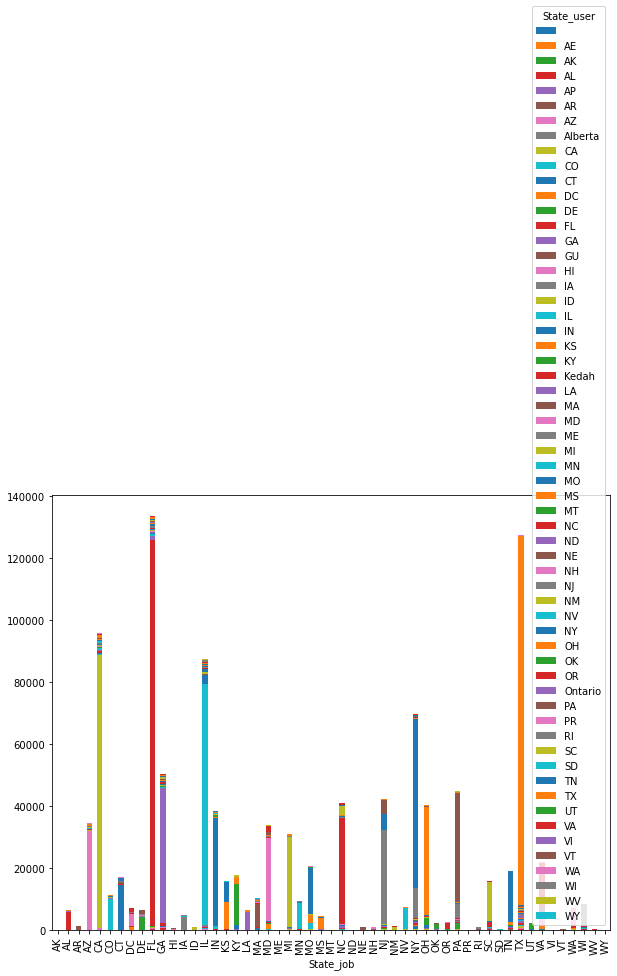

In [11]:
# Let's plot a unstacked bar char
grouped = all_records_df.dropna().groupby(['State_job', 'State_user'])['State_user'].count().unstack('State_user').fillna(0)
grouped.plot(kind="bar",stacked=True,figsize=(10,8))


In the graph we can see that for each bar there is one main color (state), which confirms that users form a particular state mostly apply for jobs at their state.

This means that it could be usefull to have a simple recommender based on country (we could also add other features such as job title, if we had them), for the cases when the user is new to the system and we still don't have information about her/him to make predictions (user cold start problem).

### How sparce is our data?
This will help us decide whether we could use a memory based approach or a model based approach in order to build our recommendations.
- A memory based approach (eg., cosine similarity or pearson correlation) is easy to create, but does not perform well when the data is sparce. Therefore, it's not scalable. 

- A model based approach uses ML to build recommendations and deals well with sparce data. Here we can use a wide variaety of models such as Matrix factorization based algorithms, Neural Networks, Bayesian Networks, Markov decision process-based models,...  

In [12]:
# We take just some of the data, to speed it up 
segment_df = all_records_df.sort_values(by=['StartDate'])[:10000]
segment_df['value'] = 1
segment_df.loc[segment_df['UserID'].isna(), 'value'] = 0

# Build the matrix
pd.crosstab(segment_df.UserID, segment_df.JobID, segment_df.value, aggfunc=np.sum)

JobID,438.0,732.0,905.0,1817.0,1819.0,2434.0,2585.0,3401.0,8286.0,10666.0,11247.0,12011.0,14692.0,15551.0,15552.0,15857.0,16116.0,16520.0,16565.0,22860.0,24541.0,25626.0,26211.0,27208.0,27510.0,27684.0,32285.0,33725.0,38418.0,39353.0,50359.0,52930.0,53167.0,62250.0,63161.0,64515.0,67176.0,70704.0,71688.0,75649.0,76459.0,83621.0,83745.0,84218.0,84789.0,95957.0,96385.0,96386.0,103056.0,103703.0,105677.0,109422.0,112051.0,112061.0,144280.0,145570.0,148023.0,148534.0,150194.0,150243.0,150310.0,151166.0,157757.0,158249.0,160604.0,160605.0,160659.0,169800.0,169943.0,170500.0,170502.0,170504.0,171392.0,173048.0,173836.0,174661.0,175496.0,175583.0,178608.0,178609.0,178784.0,181306.0,188982.0,189043.0,191818.0,194641.0,195998.0,196887.0,197567.0,198330.0,198596.0,201986.0,202224.0,202225.0,202388.0,204309.0,205188.0,205205.0,216894.0,217677.0,218235.0,219302.0,220578.0,220962.0,223661.0,223789.0,228566.0,228983.0,230246.0,234556.0,235347.0,240165.0,241883.0,242410.0,242442.0,243188.0,245290.0,246030.0,249637.0,250221.0,250984.0,251065.0,252805.0,253324.0,254598.0,259555.0,262502.0,262638.0,264834.0,267299.0,267394.0,267979.0,269214.0,273208.0,276640.0,276641.0,278758.0,279297.0,280606.0,281480.0,281787.0,283065.0,284082.0,284352.0,284372.0,285050.0,285500.0,285711.0,286156.0,296469.0,297076.0,298457.0,300005.0,300453.0,300455.0,301118.0,301727.0,301876.0,313431.0,314422.0,314646.0,315216.0,315403.0,316766.0,317120.0,317730.0,322489.0,324463.0,324465.0,325154.0,328447.0,332728.0,333274.0,335547.0,338038.0,338039.0,338854.0,346409.0,347968.0,356298.0,357425.0,362514.0,370852.0,370948.0,371068.0,374503.0,376593.0,378277.0,378719.0,380681.0,381410.0,385811.0,390424.0,399240.0,400363.0,403893.0,410626.0,430641.0,444308.0,445227.0,446002.0,447233.0,447234.0,447474.0,449011.0,449109.0,455074.0,455345.0,456810.0,458849.0,462827.0,463153.0,465297.0,468730.0,470647.0,470671.0,472507.0,473505.0,474244.0,474355.0,474356.0,475449.0,475839.0,477454.0,478051.0,479485.0,480153.0,493115.0,494727.0,496253.0,497093.0,499474.0,500218.0,504343.0,508334.0,511006.0,519964.0,522835.0,523045.0,523903.0,525618.0,525777.0,534578.0,535604.0,540351.0,545670.0,547054.0,550039.0,550528.0,551753.0,...,573027.0,575050.0,577102.0,579011.0,582892.0,583764.0,584548.0,584888.0,585476.0,585980.0,587108.0,595914.0,596198.0,597002.0,599094.0,600468.0,601466.0,601769.0,601771.0,601918.0,611982.0,612823.0,614254.0,615932.0,616750.0,616945.0,617116.0,624683.0,625659.0,626389.0,626443.0,628313.0,628689.0,630862.0,632906.0,635277.0,638299.0,638610.0,638914.0,648119.0,648232.0,651267.0,662246.0,664866.0,665619.0,667428.0,668152.0,670536.0,672583.0,672584.0,675693.0,680472.0,684925.0,690163.0,690356.0,695299.0,702611.0,709354.0,711660.0,711682.0,737578.0,740116.0,742978.0,744106.0,746686.0,750081.0,752236.0,752511.0,752863.0,753065.0,755714.0,756280.0,756661.0,756959.0,757647.0,760319.0,760838.0,760882.0,760883.0,761767.0,762696.0,762697.0,768180.0,770337.0,770417.0,775081.0,779733.0,781350.0,786399.0,789920.0,793249.0,795160.0,795799.0,796775.0,796928.0,796997.0,797030.0,797529.0,798248.0,800620.0,800801.0,802669.0,803252.0,803706.0,810564.0,818050.0,819927.0,820300.0,823913.0,824337.0,828778.0,830777.0,834828.0,835268.0,845367.0,852765.0,853519.0,858570.0,861665.0,862062.0,864004.0,865022.0,868076.0,871857.0,873445.0,874340.0,874424.0,874946.0,875874.0,878480.0,879594.0,880605.0,880729.0,881497.0,881643.0,882074.0,882154.0,882266.0,884003.0,885544.0,887720.0,896336.0,897406.0,897660.0,898279.0,898553.0,898905.0,899649.0,900006.0,900315.0,900808.0,901250.0,901353.0,901355.0,905735.0,908782.0,910035.0,910151.0,912288.0,918639.0,918642.0,918801.0,921786.0,922054.0,922500.0,925392.0,926154.0,927861.0,927862.0,930355.0,934456.0,935378.0,939218.0,940257.0,945805.0,949255.0,950556.0,951308.0,952725.0,958075.0,969029.0,969678.0,970063.0,970225.0,973593.0,974315.0,975781.0,977604.0,981319.0,981641.0,994583.0,995520.0,1006539.0,1010164.0,1012502.0,1013647.0,1013750.0,1015934.0,1017805.0,10

It looks pretty sparce to me, therefore a model based approach might be more appropriate.

### Do offers with closer start date get more conversions?
If there is a thrend, we could use this feature to explore new offers more efficiently.

In [13]:
# We can remove the offers without any application
segment_df = all_records_df[~all_records_df['ApplicationDate'].isnull()]

# First of all, let's convert dates to datetime
segment_df[['ApplicationDate','StartDate']] = segment_df[['ApplicationDate','StartDate']].apply(pd.to_datetime)

# Calculate the difference in hours between applicationDate and StartDate
segment_df['time_difference'] =(segment_df['ApplicationDate'] - segment_df['StartDate']).apply(lambda x : (x.days * 24) + x.seconds // 3600)

/Users/iirati.urabain/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-13-224bed8ab5e4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_df['time_difference'] =(segment_df['ApplicationDate'] - segment_df['StartDate']).apply(lambda x : (x.days * 24) + x.seconds // 3600)


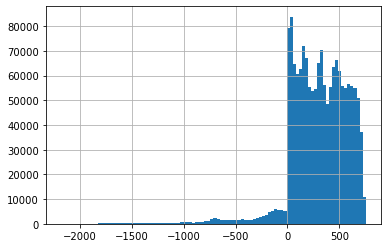

In [14]:
segment_df['time_difference'].hist(bins=100)

Here we can see:
- There is a slight thrend where shorter time intervals get few more conversions.
- There are even some negative values 

### KPI 1: Offers conversion ratios
To evaluate whether an offer works well I would generally calculate conversion rates. These are calculated by dividing the number of conversions (in this case applications) with the number of impressions. Unfortunatelly impressions are not included in this dataset. 

To be able to evaluate how well an offer performs in comparison with other offers in a particular state, we can calculate conversion ratios in a different way:

CR = #conversions for an offer / #total conversions 

This will allow us to compare offers whithin a particular state.


In [15]:
# we will just use the merged file we previously calculated, that only has conversions
# Here we calculate the CR of each Job per state
grouped_CR = users_join_df.groupby(['State', 'JobID'])['UserID'].count().groupby(level = 0).transform(lambda x: x/x.sum() * 100).reset_index().rename(columns={'UserID':'percentage'})


In [16]:
# Here we can have a look at some states to double check
grouped_CR[grouped_CR['State']== 'FL'].head(300)

,State,JobID,percentage
87569,FL,10.0,0.001047
87570,FL,11.0,0.005236
87571,FL,18.0,0.013613
87572,FL,21.0,0.002094
87573,FL,22.0,0.001047
87574,FL,23.0,0.001571
87575,FL,24.0,0.000524
87576,FL,30.0,0.002618
87577,FL,31.0,0.000524
87578,FL,34.0,0.006283


Eyeballing the data a bit from few popular states, it looks like there are not that many offers that get a high number of conversions.

### KPI 2: First time users ratio to understand user cold start problem
User cold start problem happens each time a new user hits the system. In these cases, we still don't have enough data to predict the user's likes and dislikes and we use simple recommenders based on most populatity items (eg., Display the 5 most popular jobs in US).

Therefore, in order to build the recommendation engine, it is important to understand what kind of users do we have: 
- Do we have a decent percentage of first time users?  
- Do we have users that signed up but never applied for anything? 
- How does the first time users ratio vary based on other metrics, such as country or job type? 

Analysing how many first time users we have will help us understand to what extent we are affected by <b>user cold start problem.</b>   

In this section I will just concentrate on calculating first time users ratio overall.

In [17]:
# Let's count the number of previous visits for each user in the last 6 months
time_window = '180d'
users_join_ordered_df = users_join_df.sort_values(by=['ApplicationDate'])

users_join_ordered_df[['ApplicationDate']] = users_join_ordered_df[['ApplicationDate']].apply(pd.to_datetime)

n_visits = users_join_ordered_df.reset_index().set_index('ApplicationDate').groupby('UserID').rolling(time_window)['index'].count().reset_index()
n_visits = n_visits.rename(columns={'index': 'n_visits'})

n_visits

,UserID,ApplicationDate,n_visits
0,7,2012-04-22 08:14:26.443,1.0
1,7,2012-04-28 12:17:58.630,2.0
2,9,2012-05-14 22:30:42.090,1.0
3,9,2012-05-14 22:38:37.243,2.0
4,9,2012-05-14 22:48:09.997,3.0
...,...,...,...
1671579,1472089,2012-06-25 23:29:44.633,11.0
1671580,1472089,2012-06-25 23:45:49.253,12.0
1671581,1472090,2012-05-12 16:40:50.483,1.0
1671582,1472090,2012-05-12 16:40:51.220,2.0


In [18]:
print("Percentage of first time users: {0}".format(str(len(n_visits[n_visits['n_visits'] == 1]) / len(n_visits) * 100)) )

Percentage of first time users: 23.313695273465168


It looks like there is a decent number of first time users, so it can be usefull to have a simple recommender for these cases.  

### KPI 3: Percentage of offers without conversions to understand item cold start problem 
Similarly, when a new offer is created we still don't know how it will perform. 

In this section I want to understand how many offers without conversions do we have.

In case we have prenty of new offers to choose from, we need to get a bit smarter in selecting the ones with the best potential to convert. 

There are diffent things we can do to explore new offers, for instance:
- We might want to mix some new offers with the most popular offers that our recommender algorithm calculates.
- We can use ML to predict an offers probability of conversion based on the offers metadata and the user's data (job type, employment type, keywords derived from job description,...)
- 
- ...

In [19]:
print("Percentage of offers without conversions: {0}".format(str(len(all_records_df[all_records_df['UserID'].isnull()]['JobID']) / len(all_records_df['JobID'].unique()) * 100)))



Percentage of offers without conversions: 66.51680207893621


we have a lot of offers that didn't get any attention, so we need to be good at selecting only the ones that are potentially good when exploring our inventory.   

### Analysis on revisiting users
Understanding our users' behavior will help us making better recommendation decisions. Things that might be insteresting to analyse in order to evaluate our system might be:
- How many searches does a user make before clicking an offer / applying?
- How much does the user need to scroll down before she/he finds something of interest? 
- How frequent does the user visit our system? Is this frequency associated with the likelihood of applying? 
- ...

Answering these questions might help us making decisions such as:
- do we want to apply an explorative or exploitative recommendation algorithm for a particular user?
- Do we apply a simple recommender (based on higher popularity) or a model based one?

Even though this analysis is not a part of this exercise, in "real life" it would definitely be a path to follow.

# STEP 2: Designing the recommendation engine
In this section I included a proposal for a recommendation engine.

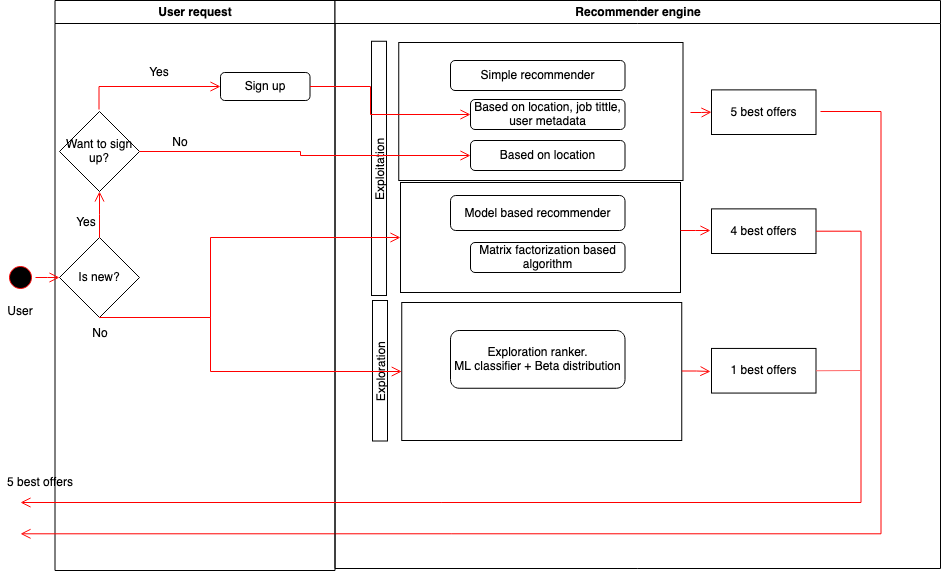

In [20]:
Image("ML_recommender_engine.png")

#### Recommendation engine
- <b>User Request. </b> When a user request arrives, the system checks whether the user was new. 
    * If the user is new, we have a user cold start problem, and thus the request would be directed to the <b>simple recommender </b>, where offers are sorted based on highest popularity. If the user signes up before this step, we might have some extra information (eg., job title, job type,...) that we can use for the sorting. 
    * If the user is not new, we can either direct it to the model based recommender (exploitation) or to the exploration ranker.

- <b>Recommender Engine - Exploitaition-exploration dilema </b>. Offers that perform well in the system need to receive traffic in order to increase conversion rates (exploitative approach). On the other hand, it is also important to keep exploring new offers in our inventory (explorative approach). A good system needs to keep a good balance in between the two, and getting this right will probably involve few AB tests. Here I propose mixing the outcomes from exploration and exploitation algorithms, where the explorative ranker would produce 20% of the results (1 offer) and the exploitative one 80% (4 offers).
    * <b> Model Based recommender - Matrix factorization </b>. Looking and the brief analysis, I concluded that a model based recommender made more sense. On top of this we need to consider we here we are using implicit feedback data (clicks, page views, purchase,...) rather than ratings. In this scenario, there are few interesting approaches:
        - Logistic Matrix factorization. See http://stanford.edu/~rezab/nips2014workshop/submits/logmat.pdf . Here, we use <b>log loss as a loss fucntion </b>. Log Loss quantifies the accuracy of a classifier bypenalising false classifications. Minimising the Log Loss is basically equivalent to maximising theaccuracy of a classifier. In our case we are dealing with [0,1] intervals, so this metric is more appropriate than MRSE (as used with ratings).
        - Non- Negative matrix factorization. This algorithm also can be used with log loss metric, and has the advantage of already being at the surprise python package. 
        - We could also experiment with other methods such as Bayesian Networks (which tend to perform quite well when we don't have much information to predict), or Neural Networks (which are gaining more popularity to solve recommendation problems). But I would start with something more simple, such as the matrix factorization.
   * <b> Exploration ranker </b>. We need to keep exploring the inventory in order to find new good offers. For this I propose to train a classification algorithm (eg., XGboost) which would take offers' metadata (job category, type,...), user's metadata (job category,...) as input, in order to predict if a particular user-offer combination would convert (1) or not (0). We would just the model's predicted probability to rank the offers. Nevertheless, it is possible that the model makes wrong predictions. To correct for that, we would use the model's predicted probability as a prior for a Beta distribution, which would take conversions and non-conversions as an input in order to predict an offer's probability to convert. Here, the model also would use a log loss as loss function. 
   


# STEP 3: Designing the architecture

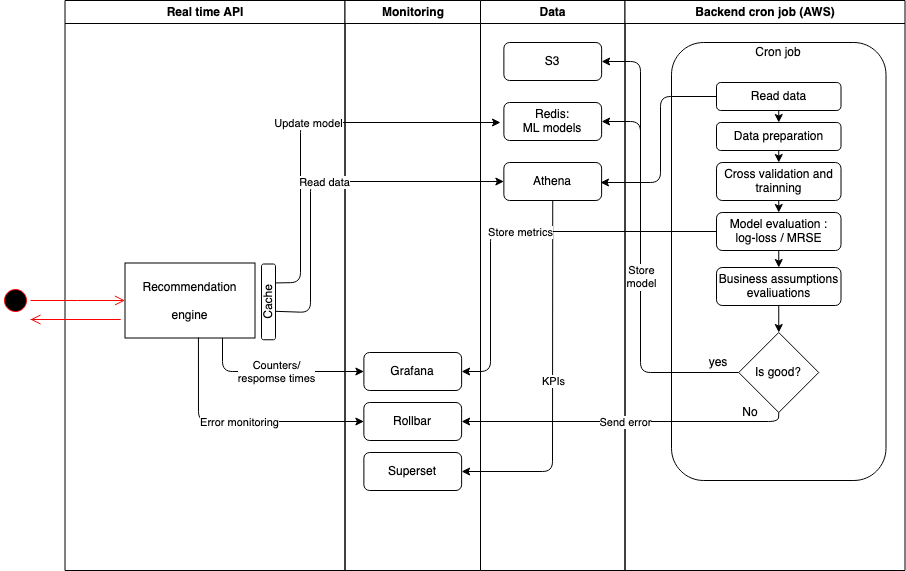

In [21]:
Image("Architecture.png")

The avobe diagram explains how the architecture could look like. 